In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# zip_path = "/content/drive/MyDrive/project.zip"


In [14]:
# path = "/content/drive/MyDrive/project"
BASE_PATH = ""


In [15]:
# !unzip -q $zip_path -d $path

>

# 1 Import libraries

In [16]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
All done


# 2 Read Data

## A- convert files to lists

In [17]:
Path_data = 'project_3_dataset/'
data = os.listdir(Path_data)
np.random.seed(42)
ageDegeneration = os.listdir(Path_data + 'ageDegeneration')
cataract = os.listdir(Path_data + 'cataract')
diabetes = os.listdir(Path_data + 'diabetes')
glaucoma = os.listdir(Path_data + 'glaucoma')
hypertension = os.listdir(Path_data + 'hypertension')
myopia = os.listdir(Path_data + 'myopia')
normal = os.listdir(Path_data + 'normal')
others = os.listdir(Path_data + 'others')


In [18]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Age Degeneration images :", len(ageDegeneration), "\n______________________________\n")
print("Number of Cataract images :", len(cataract), "\n______________________________\n")
print("Number of Diabetes images :", len(diabetes), "\n______________________________\n")
print("Number of Glaucoma images :", len(glaucoma), "\n______________________________\n")
print("Number of Hypertension images :", len(hypertension), "\n______________________________\n")
print("Number of Myopia images :", len(myopia), "\n______________________________\n")
print("Number of Normal images :", len(normal), "\n______________________________\n")
print("Number of Others images :", len(others), "\n______________________________\n")

classes names : ['ageDegeneration', 'cataract', 'diabetes', 'glaucoma', 'hypertension', 'myopia', 'normal', 'others'] 
______________________________

Number of classes : 8 
______________________________

Number of Age Degeneration images : 7152 
______________________________

Number of Cataract images : 7812 
______________________________

Number of Diabetes images : 7870 
______________________________

Number of Glaucoma images : 7620 
______________________________

Number of Hypertension images : 6845 
______________________________

Number of Myopia images : 7474 
______________________________

Number of Normal images : 7982 
______________________________

Number of Others images : 7630 
______________________________



### As noticed above: data  imbalanced

## B- Create a dataframe

In [19]:
# Get Paths


# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

df = pd.concat([Paths, Labels], axis = 1)
df.to_csv(BASE_PATH + 'df.csv', index = False)
df.head(5)

,Paths,Labels
0,project_3_dataset/ageDegeneration\image0.png,ageDegeneration
1,project_3_dataset/ageDegeneration\image1.png,ageDegeneration
2,project_3_dataset/ageDegeneration\image10.png,ageDegeneration
3,project_3_dataset/ageDegeneration\image100.png,ageDegeneration
4,project_3_dataset/ageDegeneration\image101.png,ageDegeneration


## Split data into train, valid, test

In [20]:
#train, valid  and test dataframes
train, testval = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

test.to_csv(BASE_PATH + 'test.csv', index = False)
valid.to_csv(BASE_PATH + 'valid.csv', index = False)
train.to_csv(BASE_PATH + 'train.csv', index = False)

train.Labels.value_counts()

Train shape:  (48308, 2)
Valid shape:  (6038, 2)
Test shape:  (6039, 2)


Labels
normal             6373
diabetes           6326
cataract           6242
others             6128
glaucoma           6030
myopia             5967
ageDegeneration    5755
hypertension       5487
Name: count, dtype: int64

## C- Data Augmentation

In [21]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 48308 validated image filenames belonging to 8 classes.
Found 6038 validated image filenames belonging to 8 classes.
Found 6039 validated image filenames belonging to 8 classes.


## D- Represent a sample

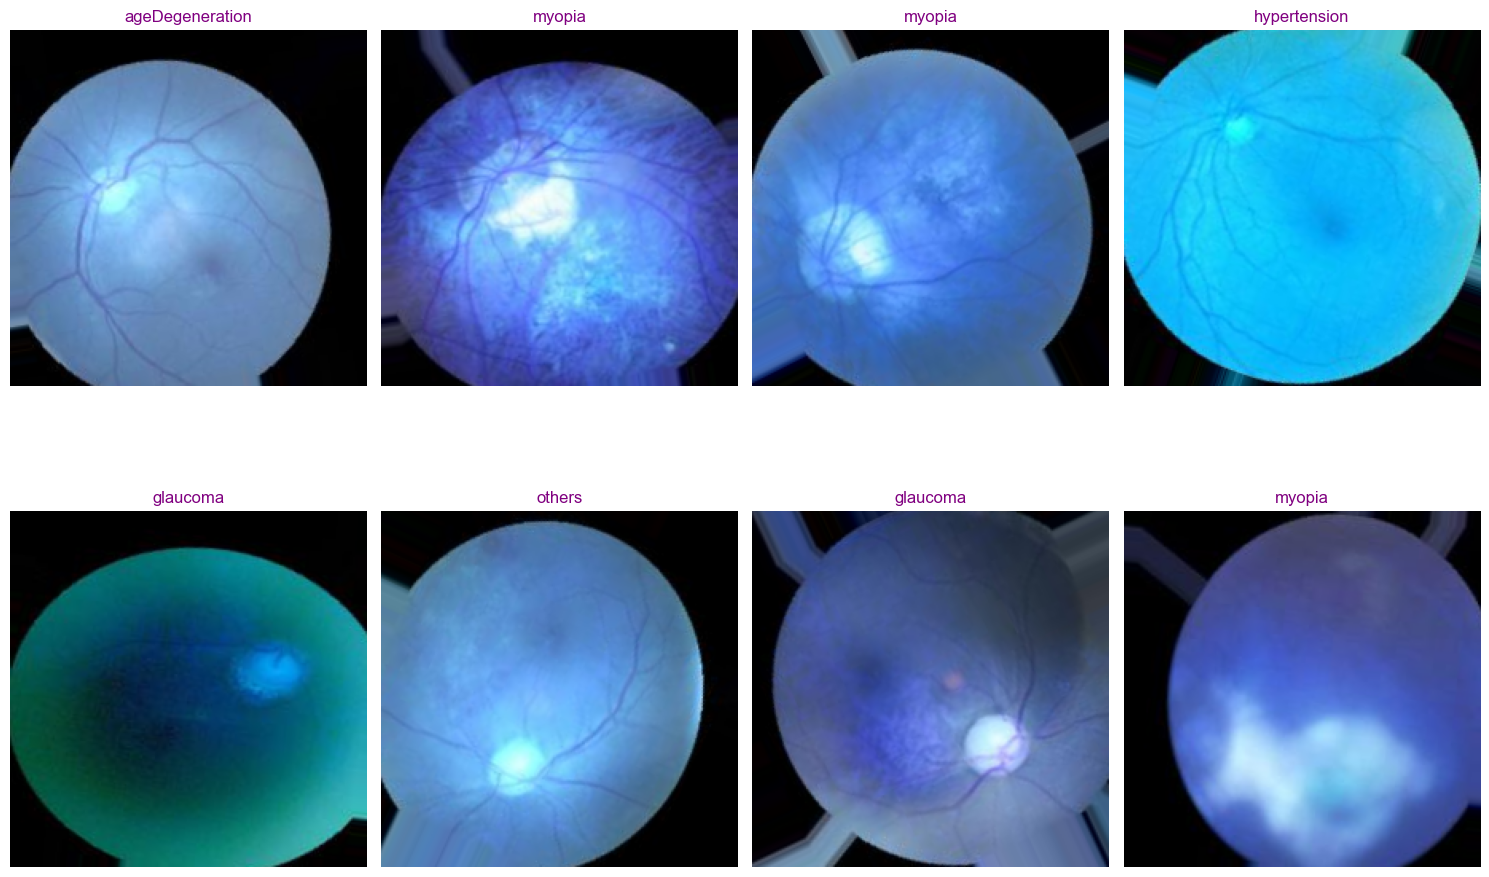

In [22]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()